<a href="https://colab.research.google.com/github/diegoeduardok/esmdynamic/blob/main/examples/esmdynamic/esmdynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ESMDynamic notebook
[Github](https://github.com/diegoeduardok/esmdynamic), [Preprint](TBD)

#### **Acknowledgements**

This notebook is based on [ColabFold's ESMFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/ESMFold.ipynb#scrollTo=POQBeXf2Xoxo).

#### **Tips and Instructions**
- Click the little ▶ play icon to the left of each cell below.
- Use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- For homo-oligomeric predictions, set copies > 1
- The download folder will contain dynamic contact map in text format, PNG image, and HTML-based visualization

#### **Colab Limitations**
- On Tesla T4 (typical free colab GPU), max total length ~ 900
- The chunk size is changed according to protein size

In [ ]:
%%time
#@title Install
#@markdown Install ESMDynamic and download weights (~3-5 min)
model_name = "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")
  os.system(f"aria2c -q -x 16 https://databank.illinois.edu/datafiles/jx4ui/download --out esmdynamic.pt &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold/esmdynamic...")
    # install esmdynamic
    os.system(f"pip install -q git+https://github.com/diegoeduardok/esmdynamic.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 39.1 µs


In [ ]:
%%time
#@title Load Model
import torch
from esm.esmdynamic import esmdynamic

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  if torch.cuda.is_available():
    model.cuda()
  model.eval().requires_grad_(False)
  model_name_ = model_name

esmdynamic_model = esmdynamic.ESMDynamic(load_esmfold=False)
esmdynamic_model.esmfold = model
esmdynamic_model.load_esmfold = True

state_dict_esmd = torch.load("esmdynamic.pt")
esmdynamic_model.load_state_dict(state_dict_esmd, strict=False)

if torch.cuda.is_available():
  esmdynamic_model.cuda()
esmdynamic_model.eval().requires_grad_(False)
print("Loading finished!")

Loading finished!
CPU times: user 581 ms, sys: 167 ms, total: 747 ms
Wall time: 757 ms


In [ ]:
#@title ##Run ESMFold/ESMDynamic
# %%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc
import plotly.express as px

def get_crop_mask_and_chain_info(sequence, insert_len=25, chain_ids=None):
    """
    Builds crop mask, residue labels with chain IDs, and boundary lines.
    """
    if chain_ids is None:
        chain_ids = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    chain_idx = 0
    mask = []
    labels = []
    boundaries = []
    res_counter = 1

    for res in sequence:
        if res == ":":
            chain_idx += 1
            res_counter = 1
            boundaries.append(len(mask))  # position after crop
            mask.extend([False] * insert_len)
        else:
            mask.append(True)
            chain_id = chain_ids[chain_idx % len(chain_ids)]
            labels.append(f"{chain_id}-{res}{res_counter}")
            res_counter += 1

    return mask, labels, boundaries

def parse_output(output):
    pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
    plddt = output["plddt"][0,:,1]

    bins = np.append(0,np.linspace(2.3125,21.6875,63))
    sm_contacts = softmax(output["distogram_logits"],-1)[0]
    sm_contacts = sm_contacts[...,bins<8].sum(-1)
    xyz = output["positions"][-1,0,:,1]
    mask = output["atom37_atom_exists"][0,:,1] == 1
    o = {"pae":pae[mask,:][:,mask],
        "plddt":plddt[mask],
        "sm_contacts":sm_contacts[mask,:][:,mask],
        "xyz":xyz[mask]}
    return o

def save_outputs(output_dir, id, contact_map, mask, labels, boundaries):
    os.makedirs(output_dir, exist_ok=True)

    idx = [i for i, keep in enumerate(mask) if keep]
    contact_map = contact_map[np.ix_(idx, idx)]

    # Save numerical data
    np.savetxt(os.path.join(output_dir, f"{id}_dyn_cont.txt"), contact_map, "%.3f")

    # Save .png with chain lines
    plt.figure(figsize=(6, 6))
    plt.matshow(contact_map, cmap='viridis')
    for pos in boundaries:
        plt.axhline(pos - 0.5, color='white', linewidth=1)
        plt.axvline(pos - 0.5, color='white', linewidth=1)
    plt.title(f"{id} Dynamic Contact Map", y=1.1)
    plt.savefig(os.path.join(output_dir, f"{id}_dyn_cont.png"))
    plt.close()

    # Save .html with Plotly
    fig = px.imshow(
        contact_map,
        labels=dict(x="Residue", y="Residue", color="Dynamic Contact Prob."),
        x=labels,
        y=labels,
        color_continuous_scale="Viridis"
    )
    for pos in boundaries:
        fig.add_shape(type="line", x0=pos - 0.5, x1=pos - 0.5, y0=-0.5, y1=len(labels) - 0.5,
                      line=dict(color="white", width=1))
        fig.add_shape(type="line", y0=pos - 0.5, y1=pos - 0.5, x0=-0.5, x1=len(labels) - 0.5,
                      line=dict(color="white", width=1))

    fig.write_html(os.path.join(output_dir, f"{id}_dyn_cont.html"))


def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "HIV1P" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 2 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

# optimized for Tesla T4
if length > 700:
    esmdynamic_model.set_chunk_size(64)
else:
    esmdynamic_model.set_chunk_size(128)

torch.cuda.empty_cache()
output = esmdynamic_model.esmfold.infer(sequence,
                                        num_recycles=num_recycles,
                                        chain_linker="X"*chain_linker,
                                        residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
    out.write(pdb_str)

# Run ESMDynamic
matrix_esmd = esmdynamic_model.predict_from_seqs(sequence)["dynamic_contact_prob"].cpu().numpy()[0, 0]
mask_esmd, labels_esmd, boundaries_esmd = get_crop_mask_and_chain_info(sequence)
save_outputs(f"{ID}/", ID, matrix_esmd, mask_esmd, labels_esmd, boundaries_esmd)

length 198
ptm: 0.784 plddt: 80.785


<Figure size 600x600 with 0 Axes>

In [ ]:
#@title Display (structure only) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

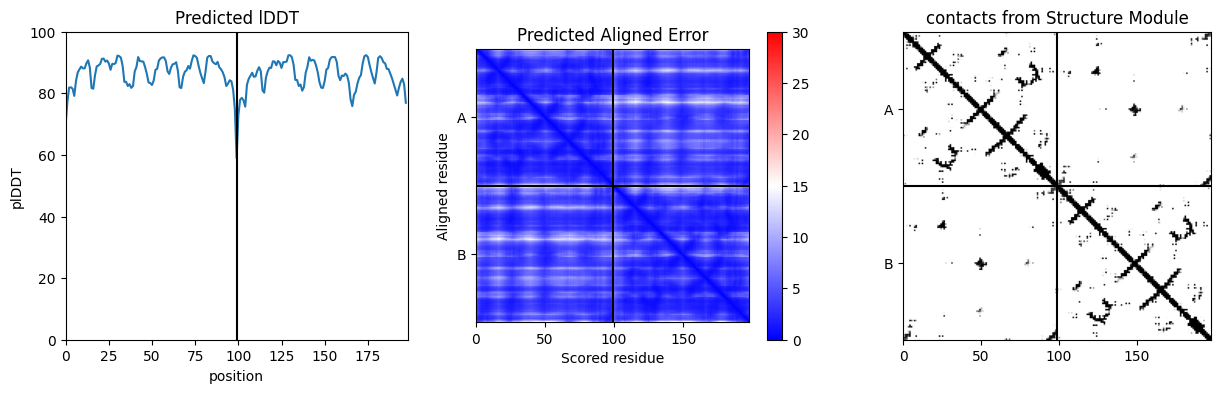

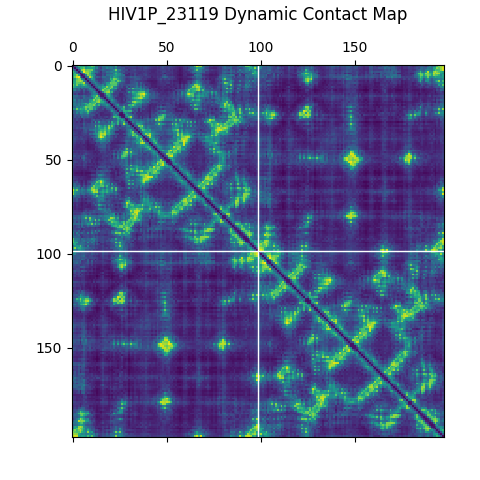

In [ ]:
#@title Show plots

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

from IPython.display import Image, display
display(Image(filename=f"{ID}/{ID}_dyn_cont.png"))

In [ ]:
#@title Download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>